In [1]:
class HungarianError(Exception):
    pass
# Import numpy. Error if fails
try:
    import numpy as np
    import matplotlib.pyplot as plt
except ImportError:
    raise HungarianError("NumPy is not installed.")

class Hungarian:
    def __init__(self, input_matrix=None):
        """
        input_matrix is a List of Lists.
        """
        if input_matrix is not None:

            # Save input
            my_matrix          = np.array(input_matrix)
            self._input_matrix = np.array(input_matrix)
            self._maxColumn    = my_matrix.shape[1]
            self._maxRow       = my_matrix.shape[0]

            # Adds 0s if any columns/rows are added. Otherwise stays unaltered
            matrix_size = max(self._maxColumn, self._maxRow)
            # my_matrix.resize(matrix_size, matrix_size)
            pad_columns = matrix_size - self._maxRow
            pad_rows    = matrix_size - self._maxColumn
            # print(pad_columns, pad_rows)
            my_matrix   = np.pad(my_matrix, ((0,pad_columns),(0,pad_rows)), 'constant', constant_values=(0))
            # print(my_matrix.shape); print()

            # Convert matrix to profit matrix if necessary
            self._cost_matrix = my_matrix
            self._size        = len(my_matrix)
            self._shape       = my_matrix.shape
            # Results from algorithm.

            self._results = []
        else:
            self._cost_matrix = None

    def get_results(self):
        """
        Get results after calculation.
        """
        return self._results
    
    def calculate(self, input_matrix=None):
        """
        Implementation of the Hungarian (Munkres) Algorithm.
        input_matrix is a List of Lists.
        """
        # Handle invalid and new matrix inputs.
        if input_matrix is None and self._cost_matrix is None:
            raise HungarianError("Invalid input")

        elif input_matrix is not None:
            self.__init__(input_matrix)

        result_matrix = self._cost_matrix.copy()

        # Step 1: Subtract row mins from each row.
        for index, row in enumerate(result_matrix):
            result_matrix[index] -= row.min()

        # Step 2: Subtract column mins from each column.
        for index, column in enumerate(result_matrix.T):
            result_matrix[:, index] -= column.min()

        # Step 3: Use minimum number of lines to cover all zeros in the matrix.
        # If the total covered rows+columns is not equal to the matrix size then adjust matrix and repeat.
        total_covered = 0

        while total_covered < self._size:
            # Find minimum number of lines to cover all zeros in the matrix and find total covered rows and columns.
            cover_zeros = CoverZeros(result_matrix)
            covered_rows = cover_zeros.get_covered_rows()
            covered_columns = cover_zeros.get_covered_columns()
            total_covered = len(covered_rows) + len(covered_columns)

            # if the total covered rows+columns is not equal to the matrix size then adjust it by min uncovered num (m).
            if total_covered < self._size:
                result_matrix = self._adjust_matrix_by_min_uncovered_num(result_matrix, covered_rows, covered_columns)

        # Step 4: Starting with the top row, work your way downwards as you make assignments.
        # Find single zeros in rows or columns.
        # Add them to final result and remove them and their associated row/column from the matrix.
        expected_results = min(self._maxColumn, self._maxRow)
        zero_locations = (result_matrix == 0)
        while len(self._results) != expected_results:
            # If number of zeros in the matrix is zero before finding all the results then an error has occurred.
            if not zero_locations.any():
                raise HungarianError("Unable to find results. Algorithm has failed.")

            # Find results and mark rows and columns for deletion
            matched_rows, matched_columns = self.__find_matches(zero_locations)

            # Make arbitrary selection
            total_matched = len(matched_rows) + len(matched_columns)
            if total_matched == 0:
                matched_rows, matched_columns = self.select_arbitrary_match(zero_locations)

            # Delete rows and columns
            for row in matched_rows:
                zero_locations[row] = False
            for column in matched_columns:
                zero_locations[:, column] = False
            # Save Results
            self.__set_results(zip(matched_rows, matched_columns))

        # Calculate total potential
        value = 0
        for row, column in self._results:
            value += self._input_matrix[row, column]
    @staticmethod
    def make_cost_matrix(profit_matrix):
        """Converts a profit matrix into a cost matrix.
        Expects NumPy objects as input.
        """
        # subtract profit matrix from a matrix made of the max value of the profit matrix
        matrix_shape = profit_matrix.shape
        offset_matrix = np.ones(matrix_shape, dtype=int) * profit_matrix.max()
        cost_matrix = offset_matrix - profit_matrix
        return cost_matrix

######################################################################################################################################
    def _adjust_matrix_by_min_uncovered_num(self, result_matrix, covered_rows, covered_columns):
        """Subtract m from every uncovered number and add m to every element covered with two lines."""
        # Calculate minimum uncovered number (m)
        elements = []
        # print(result_matrix.shape)
        for row_index, row in enumerate(result_matrix):
            if row_index not in covered_rows:
                for index, element in enumerate(row):
                    if index not in covered_columns:
                        elements.append(element)
        # print(f'els = {len(elements)}')
        min_uncovered_num = min(elements)
        # Add m to every covered element
        adjusted_matrix = result_matrix
        for row in covered_rows:
            adjusted_matrix[row] += min_uncovered_num
        for column in covered_columns:
            adjusted_matrix[:, column] += min_uncovered_num
        # Subtract m from every element
        m_matrix = np.ones(self._shape, dtype=int) * min_uncovered_num
        adjusted_matrix -= m_matrix
        return adjusted_matrix

    def __find_matches(self, zero_locations):
        """Returns rows and columns with matches in them."""
        marked_rows = np.array([], dtype=int)
        marked_columns = np.array([], dtype=int)
        # Mark rows and columns with matches
        # Iterate over rows
        for index, row in enumerate(zero_locations):
            row_index = np.array([index])
            if np.sum(row) == 1:
                column_index, = np.where(row)
                marked_rows, marked_columns = self.__mark_rows_and_columns(marked_rows, marked_columns, row_index,
                                                                           column_index)
        # Iterate over columns
        for index, column in enumerate(zero_locations.T):
            column_index = np.array([index])
            if np.sum(column) == 1:
                row_index, = np.where(column)
                marked_rows, marked_columns = self.__mark_rows_and_columns(marked_rows, marked_columns, row_index,
                                                                           column_index)
        return marked_rows, marked_columns
    @staticmethod

    def __mark_rows_and_columns(marked_rows, marked_columns, row_index, column_index):
        """Check if column or row is marked. If not marked then mark it."""
        new_marked_rows = marked_rows
        new_marked_columns = marked_columns
        if not (marked_rows == row_index).any() and not (marked_columns == column_index).any():
            new_marked_rows = np.insert(marked_rows, len(marked_rows), row_index)
            new_marked_columns = np.insert(marked_columns, len(marked_columns), column_index)
        return new_marked_rows, new_marked_columns
    @staticmethod

    def select_arbitrary_match(zero_locations):
        """Selects row column combination with minimum number of zeros in it."""
        # Count number of zeros in row and column combinations
        rows, columns = np.where(zero_locations)
        zero_count = []
        for index, row in enumerate(rows):
            total_zeros = np.sum(zero_locations[row]) + np.sum(zero_locations[:, columns[index]])
            zero_count.append(total_zeros)
        # Get the row column combination with the minimum number of zeros.
        indices = zero_count.index(min(zero_count))
        row = np.array([rows[indices]])
        column = np.array([columns[indices]])
        return row, column

    def __set_results(self, result_lists):
        """Set results during calculation."""
        # Check if results values are out of bound from input matrix (because of matrix being padded).
        # Add results to results list.
        for result in result_lists:
            row, column = result
            if row < self._maxRow and column < self._maxColumn:
                new_result = (int(row), int(column))
                self._results.append(new_result)

class CoverZeros:
    def __init__(self, matrix):
    
        # Find zeros in matrix
        self._zero_locations = (matrix == 0)
        self._shape = matrix.shape

        # Choices starts without any choices made.
        self._choices = np.zeros(self._shape, dtype=bool)
        self._marked_rows = []
        self._marked_columns = []

        # marks rows and columns
        self.__calculate()

        # Draw lines through all unmarked rows and all marked columns.
        self._covered_rows = list(set(range(self._shape[0])) - set(self._marked_rows))
        self._covered_columns = self._marked_columns

    def get_covered_rows(self):
        """Return list of covered rows."""
        return self._covered_rows

    def get_covered_columns(self):
        """Return list of covered columns."""
        return self._covered_columns

    def __calculate(self):
        while True:
            # Erase all marks.
            self._marked_rows = []
            self._marked_columns = []

            # Mark all rows in which no choice has been made.
            for index, row in enumerate(self._choices):
                if not row.any():
                    self._marked_rows.append(index)

            # If no marked rows then finish.
            if not self._marked_rows:
                return True
            # Mark all columns not already marked which have zeros in marked rows.
            num_marked_columns = self.__mark_new_columns_with_zeros_in_marked_rows()

            # If no new marked columns then finish.
            if num_marked_columns == 0:
                return True
            # While there is some choice in every marked column.
            while self.__choice_in_all_marked_columns():
                # Some Choice in every marked column.
                # Mark all rows not already marked which have choices in marked columns.
                num_marked_rows = self.__mark_new_rows_with_choices_in_marked_columns()
                # If no new marks then Finish.
                if num_marked_rows == 0:
                    return True
                # Mark all columns not already marked which have zeros in marked rows.
                num_marked_columns = self.__mark_new_columns_with_zeros_in_marked_rows()

                # If no new marked columns then finish.
                if num_marked_columns == 0:
                    return True
            # No choice in one or more marked columns.
            # Find a marked column that does not have a choice.
            choice_column_index = self.__find_marked_column_without_choice()
            while choice_column_index is not None:
                # Find a zero in the column indexed that does not have a row with a choice.
                choice_row_index = self.__find_row_without_choice(choice_column_index)

                # Check if an available row was found.
                new_choice_column_index = None
                if choice_row_index is None:
                    # Find a good row to accomodate swap. Find its column pair.
                    choice_row_index, new_choice_column_index = \
                        self.__find_best_choice_row_and_new_column(choice_column_index)
                    # Delete old choice.
                    self._choices[choice_row_index, new_choice_column_index] = False
                # Set zero to choice.
                self._choices[choice_row_index, choice_column_index] = True
                # Loop again if choice is added to a row with a choice already in it.
                choice_column_index = new_choice_column_index

    def __mark_new_columns_with_zeros_in_marked_rows(self):
        """Mark all columns not already marked which have zeros in marked rows."""
        num_marked_columns = 0
        for index, column in enumerate(self._zero_locations.T):
            if index not in self._marked_columns:
                if column.any():
                    row_indices, = np.where(column)
                    zeros_in_marked_rows = (set(self._marked_rows) & set(row_indices)) != set([])
                    if zeros_in_marked_rows:
                        self._marked_columns.append(index)
                        num_marked_columns += 1
        return num_marked_columns

    def __mark_new_rows_with_choices_in_marked_columns(self):
        """Mark all rows not already marked which have choices in marked columns."""
        num_marked_rows = 0
        for index, row in enumerate(self._choices):
            if index not in self._marked_rows:
                if row.any():
                    column_index, = np.where(row)
                    if column_index in self._marked_columns:
                        self._marked_rows.append(index)
                        num_marked_rows += 1
        return num_marked_rows

    def __choice_in_all_marked_columns(self):
        """Return Boolean True if there is a choice in all marked columns. Returns boolean False otherwise."""
        for column_index in self._marked_columns:
            if not self._choices[:, column_index].any():
                return False
        return True

    def __find_marked_column_without_choice(self):
        """Find a marked column that does not have a choice."""
        for column_index in self._marked_columns:
            if not self._choices[:, column_index].any():
                return column_index
        raise HungarianError("Could not find a column without a choice. Failed to cover matrix zeros. Algorithm has failed.")

    def __find_row_without_choice(self, choice_column_index):
        """Find a row without a choice in it for the column indexed. If a row does not exist then return None."""
        row_indices, = np.where(self._zero_locations[:, choice_column_index])
        for row_index in row_indices:
            if not self._choices[row_index].any():
                return row_index
        # All rows have choices. Return None.
        return None

    def __find_best_choice_row_and_new_column(self, choice_column_index):
        """
        Find a row index to use for the choice so that the column that needs to be changed is optimal.
        Return a random row and column if unable to find an optimal selection.
        """
        row_indices, = np.where(self._zero_locations[:, choice_column_index])
        for row_index in row_indices:
            column_indices, = np.where(self._choices[row_index])
            column_index = column_indices[0]
            if self.__find_row_without_choice(column_index) is not None:
                return row_index, column_index
        # Cannot find optimal row and column. Return a random row and column.
        from random import shuffle
        shuffle(row_indices)
        column_index, = np.where(self._choices[row_indices[0]])
        return row_indices[0], column_index[0]

In [3]:
def coordinates2image(l, shape):
  r = np.zeros(shape)
  # print(l.max(axis= 0), shape)
  # r[l[:,0], l[:,1]] = 1
  r[l[:,1], l[:,0]] = 255
  return r

In [38]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [40]:
image_path  ="/content/drive/My Drive/Machine Learning/ML Project/fox.jpg"
points_path = "/content/drive/My Drive/Machine Learning/ML Project/foxPoints.txt"
import cv2
image=cv2.imread(image_path);
point = []
with open(points_path) as file:
  for line in file:
    x,y = line.split()
    point.append((int(x), int(y)))

points = np.array(point)

In [41]:
No_Robots = 100
Initial_Positions = np.array([
  np.random.randint(image.shape[1], size= No_Robots),
  np.random.randint(image.shape[0], size= No_Robots),
]).T

In [42]:
def GetDistanceMatrix(Initial, Final):
  Initial = np.array(Initial)
  Final = np.array(Final)

  Displacements = Initial.reshape(-1,1,2) - Final.reshape(1,-1,2)
  Distances     = np.linalg.norm(Displacements, axis= 2)

  return Distances

In [43]:
DistMatrix = GetDistanceMatrix(Initial_Positions, points)
Hung = Hungarian(DistMatrix)
try:
  Hung.calculate()
except Exception:
  pass

In [44]:
Hung_Results = Hung.get_results()
Hung_Results

[(0, 37),
 (1, 87),
 (3, 84),
 (4, 50),
 (6, 23),
 (8, 14),
 (12, 18),
 (20, 80),
 (22, 10),
 (23, 67),
 (27, 9),
 (28, 16),
 (29, 1),
 (31, 81),
 (39, 91),
 (41, 2),
 (42, 8),
 (49, 0),
 (51, 58),
 (54, 45),
 (58, 88),
 (59, 13),
 (60, 73),
 (66, 4),
 (67, 30),
 (68, 79),
 (70, 32),
 (72, 76),
 (74, 24),
 (76, 63),
 (77, 46),
 (78, 3),
 (80, 55),
 (81, 35),
 (82, 31),
 (84, 90),
 (85, 60),
 (86, 96),
 (87, 98),
 (89, 25),
 (90, 44),
 (95, 66),
 (98, 28),
 (99, 72),
 (56, 22),
 (65, 34),
 (26, 42),
 (16, 93),
 (5, 99),
 (9, 83),
 (11, 62),
 (17, 65),
 (30, 59),
 (32, 64),
 (38, 39),
 (40, 47),
 (43, 6),
 (44, 29),
 (52, 19),
 (79, 92),
 (83, 33),
 (92, 21),
 (96, 41),
 (97, 95),
 (34, 15),
 (53, 20),
 (10, 53),
 (13, 17),
 (21, 43),
 (48, 11),
 (62, 85),
 (88, 5),
 (91, 12),
 (15, 7),
 (35, 51),
 (57, 56),
 (19, 71),
 (7, 89),
 (47, 82),
 (61, 36),
 (36, 48),
 (37, 54),
 (25, 69),
 (14, 68),
 (45, 86),
 (46, 70),
 (63, 74),
 (75, 38),
 (69, 49),
 (94, 52),
 (24, 57),
 (93, 94),
 (50, 4

In [45]:
Hung_Results = np.array(Hung_Results)
Mask = np.isin(Hung_Results[:,0], range(No_Robots))

Final_Positions = Hung_Results[Mask][:,1]
Final_Points    = points[Final_Positions]

Final_Points

array([[ 99, 242],
       [ 99, 260],
       [211, 193],
       [110,  25],
       [218, 207],
       [226,  39],
       [250, 257],
       [204, 223],
       [222, 186],
       [248, 179],
       [226,  99],
       [238, 169],
       [ 89, 261],
       [ 35, 233],
       [ 64, 240],
       [110, 234],
       [164, 108],
       [106,  22],
       [102, 233],
       [149, 233],
       [250, 169],
       [250, 147],
       [250, 119],
       [133, 239],
       [116, 174],
       [129, 157],
       [ 97, 264],
       [ 98,  11],
       [191,  99],
       [248,  74],
       [236,  48],
       [219, 188],
       [ 97, 182],
       [131, 240],
       [ 55, 199],
       [222,  95],
       [127, 162],
       [163,  36],
       [ 57, 233],
       [183,  32],
       [181, 101],
       [201, 222],
       [247, 180],
       [171, 221],
       [178, 220],
       [143, 235],
       [101, 249],
       [186, 220],
       [219,  98],
       [108,  23],
       [128, 159],
       [217,  35],
       [189,

In [47]:
image_size = image.shape
print(image_size)
img = coordinates2image(Final_Points, image_size)

(283, 283, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


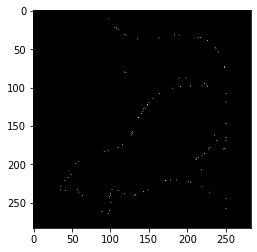

In [48]:
plt.imshow(img, cmap= 'gray')

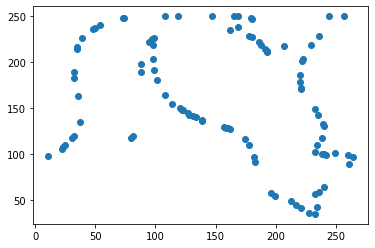

In [49]:
plt.plot(Final_Points[:,1], Final_Points[:,0], 'o')

# **Collision** **Avoidance** **Part**

In [50]:
import numpy as np

def move(X, points):

    X      = np.array(X)
    points = np.array(points)

    assert X.shape == points.shape, 'initial positions and final positions must have equal shape'
    
    boundry  = 2
    velocity = 0.9
    
    X = X.astype(float)
    reached = np.array([False])

    while not reached.all():
        
        colliding = (boundry > np.linalg.norm(X[:,None] - X[:,:,None], axis= 1)).all(axis= 1) # index of colliding robots
        reached   = (np.rint(X) == points).all(axis= 1)                                       # index of robots at thair final positions

        # direction of required motion
        direction  = points - X
        direction /= np.linalg.norm(direction, axis= 1, keepdims= True)
        direction  = np.nan_to_num(direction)
        
        # update values of current positions
        update = direction * velocity
        
        # updating non colliding robots
        X[~colliding & ~reached] = X[~colliding & ~reached] + update[~colliding & ~reached]
        
        # updating colliding robots
        if (colliding & ~reached).any():
            i = np.random.choice(*np.where(colliding & ~reached), size= 1)
            X[i] = X[i] + update[i]
        
        yield np.rint(X).astype(int)

In [51]:
# print(
#     f'{Initial_Positions.shape}',
#     f'{Final_Points.shape}'
# )
for current_position in move(Initial_Positions, Final_Points):
  # print(current_position.max(axis= 0), image.shape)
  plt.imshow(coordinates2image(current_position, image.shape))
  plt.show()

Output hidden; open in https://colab.research.google.com to view.